In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zaurasgarli","key":"b42132803d2418f7a5d760d7db2fd804"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ahmaddaffaabiyyu/annotated-yolov12-blood-cell-dataset

Dataset URL: https://www.kaggle.com/datasets/ahmaddaffaabiyyu/annotated-yolov12-blood-cell-dataset
License(s): apache-2.0
  0% 0.00/112M [00:00<?, ?B/s]
100% 112M/112M [00:00<00:00, 1.25GB/s]


In [5]:
!unzip -q /content/annotated-yolov12-blood-cell-dataset.zip

In [6]:
import os

file_path = "/content/Blood_Cell_Classification.v2i.yolov12/train/labels.cache"

if os.path.exists(file_path):
    os.remove(file_path)
    print("File deleted.")
else:
    print("File not found.")

File deleted.


In [7]:
import os

file_path = "/content/Blood_Cell_Classification.v2i.yolov12/valid/labels.cache"

if os.path.exists(file_path):
    os.remove(file_path)
    print("File deleted.")
else:
    print("File not found.")


File deleted.


In [8]:
class_names = ['eosinophil', 'lymphocyte', 'neutrophil', 'platelet']

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import random

def view_random_image(target_dir):
  target_dir = pathlib.Path(target_dir)
  random_image = random.choice(os.listdir(target_dir))
  img = mpimg.imread(target_dir / random_image)

  plt.imshow(img)
  plt.axis('off')
  return img.shape

(640, 640, 3)

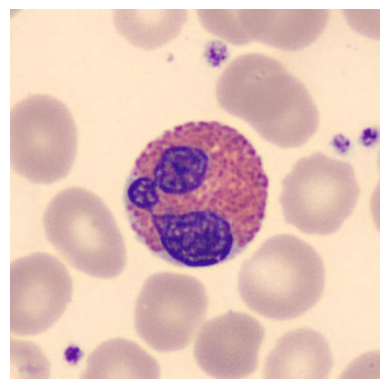

In [10]:
view_random_image('/content/Blood_Cell_Classification.v2i.yolov12/train/images')

In [11]:
import os
import glob

def get_image_label_pairs(base_path, subset='train'):
    img_folder = os.path.join(base_path, subset, 'images')
    lbl_folder = os.path.join(base_path, subset, 'labels')

    image_paths = sorted(glob.glob(os.path.join(img_folder, '*.jpg')))
    label_paths = []

    for img_path in image_paths:
        base_name = os.path.basename(img_path).replace('.jpg', '.txt')
        label_path = os.path.join(lbl_folder, base_name)
        label_paths.append(label_path)

    return image_paths, label_paths

base_path = "/content/Blood_Cell_Classification.v2i.yolov12"
train_image_paths, train_label_paths = get_image_label_pairs(base_path, 'train')
val_image_paths, val_label_paths = get_image_label_pairs(base_path, 'valid')
test_image_paths, test_label_paths = get_image_label_pairs(base_path, 'test')

In [12]:
import numpy as np

def parse_annotation_file(annotation_path, S=7, B=2, C=4):
    target = np.zeros((S, S, B * 5 + C), dtype=np.float32)

    with open(annotation_path.numpy().decode('utf-8'), 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, w, h = map(float, parts[1:5])

        i = int(y_center * S)
        j = int(x_center * S)

        if target[i, j, 4] == 0:
            target[i, j, 0:5] = [x_center * S - j, y_center * S - i, w, h, 1.0]
            target[i, j, 5 * B + class_id] = 1.0

    return target


In [13]:
def load_image_and_label(image_path, label_path):
    # Read and process image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (448, 448))
    image = image / 255.0  # normalize to [0,1]

    # Parse label using py_function (wrap numpy function)
    label = tf.py_function(func=parse_annotation_file,
                           inp=[label_path],
                           Tout=tf.float32)
    label.set_shape((7, 7, 14))  # Set shape after py_function

    return image, label

def create_dataset(image_paths, label_paths, batch_size=16, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths))
    ds = ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [14]:
train_dataset = create_dataset(train_image_paths, train_label_paths, batch_size=16)
val_dataset = create_dataset(val_image_paths, val_label_paths, batch_size=16, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_label_paths, batch_size=16, shuffle=False)

In [15]:
class YZ_YoloV1(tf.keras.Model):
  def __init__(self, C=4):
    super(YZ_YoloV1, self).__init__()
    self.S = 7
    self.B = 2
    self.C = C
    #1
    self.conv1 = tf.keras.layers.Conv2D(kernel_size=7, filters=64, strides=2, padding='same')
    self.act1 = tf.keras.layers.LeakyReLU(0.1)
    self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')
    #2
    self.conv2 = tf.keras.layers.Conv2D(kernel_size=3, filters=192, padding='same')
    self.act2 = tf.keras.layers.LeakyReLU(0.1)
    self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')
    #3
    self.conv3 = tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same')
    self.act3 = tf.keras.layers.LeakyReLU(0.1)
    self.conv4 = tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same')
    self.act4 = tf.keras.layers.LeakyReLU(0.1)
    self.conv5 = tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same')
    self.act5 = tf.keras.layers.LeakyReLU(0.1)
    self.conv6 = tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same')
    self.act6 = tf.keras.layers.LeakyReLU(0.1)
    self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')
    #4
    self.block4 = []
    for _ in range(4):
      self.block4.append(tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same'))
      self.block4.append(tf.keras.layers.LeakyReLU(0.1))
      self.block4.append(tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same'))
      self.block4.append(tf.keras.layers.LeakyReLU(0.1))
    self.conv_block4 = tf.keras.Sequential(self.block4)
    self.conv7 = tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same')
    self.act7 = tf.keras.layers.LeakyReLU(0.1)
    self.conv8 = tf.keras.layers.Conv2D(kernel_size=3, filters=1024, padding='same')
    self.act8 = tf.keras.layers.LeakyReLU(0.1)
    self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')
    #5
    self.block5 = []
    for _ in range(2):
      self.block5.append(tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same'))
      self.block5.append(tf.keras.layers.LeakyReLU(0.1))
      self.block5.append(tf.keras.layers.Conv2D(kernel_size=3, filters=1024, padding='same'))
      self.block5.append(tf.keras.layers.LeakyReLU(0.1))
    self.conv_block5 = tf.keras.Sequential(self.block5)
    self.conv9 = tf.keras.layers.Conv2D(kernel_size=3, filters=1024, padding='same')
    self.act9 = tf.keras.layers.LeakyReLU(0.1)
    self.conv10 = tf.keras.layers.Conv2D(kernel_size=3, filters=1024, strides=2, padding='same')
    self.act10 = tf.keras.layers.LeakyReLU(0.1)
    #6
    self.conv11 = tf.keras.layers.Conv2D(kernel_size=3, filters=1024, padding='same')
    self.act11 = tf.keras.layers.LeakyReLU(0.1)
    self.conv12 = tf.keras.layers.Conv2D(kernel_size=3, filters=1024, padding='same')
    self.act12 = tf.keras.layers.LeakyReLU(0.1)
    #7
    self.flat = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(4096)
    self.act13 = tf.keras.layers.LeakyReLU(0.1)
    self.drop = tf.keras.layers.Dropout(0.5)
    self.dense2 = tf.keras.layers.Dense(self.S * self.S * (self.B * 5 + self.C))
    self.reshape = tf.keras.layers.Reshape((self.S, self.S, self.B * 5 + self.C))
  def call(self, x, training=False):
    #1
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    #2
    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)
    #3
    x = self.conv3(x)
    x = self.act3(x)
    x = self.conv4(x)
    x = self.act4(x)
    x = self.conv5(x)
    x = self.act5(x)
    x = self.conv6(x)
    x = self.act6(x)
    x = self.pool3(x)
    #4
    x = self.conv_block4(x)
    x = self.conv7(x)
    x = self.act7(x)
    x = self.conv8(x)
    x = self.act8(x)
    x = self.pool4(x)
    #5
    x = self.conv_block5(x)
    x = self.conv9(x)
    x = self.act9(x)
    x = self.conv10(x)
    x = self.act10(x)
    #6
    x = self.conv11(x)
    x = self.act11(x)
    x = self.conv12(x)
    x = self.act12(x)
    #7
    x = self.flat(x)
    x = self.dense1(x)
    x = self.act13(x)
    x = self.drop(x, training=training)
    x = self.dense2(x)
    output = self.reshape(x)
    return output

In [16]:
model = YZ_YoloV1(C=4)

In [17]:
class YoloV1Loss(tf.keras.losses.Loss):
    def __init__(self, S=7, B=2, C=4):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = 5.0
        self.lambda_noobj = 0.5

    def call(self, y_true, y_pred):
        y_true = tf.reshape(y_true, (-1, self.S, self.S, 5 * self.B + self.C))
        y_pred = tf.reshape(y_pred, (-1, self.S, self.S, 5 * self.B + self.C))

        # Split into components
        pred_boxes = y_pred[..., :5 * self.B]
        pred_classes = y_pred[..., 5 * self.B:]

        true_boxes = y_true[..., :5 * self.B]
        true_classes = y_true[..., 5 * self.B:]

        # For each box: (x, y, w, h, confidence)
        pred_boxes = tf.reshape(pred_boxes, (-1, self.S, self.S, self.B, 5))
        true_boxes = tf.reshape(true_boxes, (-1, self.S, self.S, self.B, 5))

        # Create object mask from ground truth (if any object exists in a cell)
        object_mask = tf.reduce_max(true_boxes[..., 4], axis=-1, keepdims=True)
        object_mask = tf.cast(object_mask > 0, tf.float32)  # shape: (batch, S, S, 1)

        # ================================
        # Localization Loss (x, y, w, h)
        # ================================
        coord_mask = tf.expand_dims(object_mask, -1)

        pred_xy = pred_boxes[..., 0:2]
        true_xy = true_boxes[..., 0:2]

        pred_wh = tf.sqrt(tf.maximum(pred_boxes[..., 2:4], 1e-6))
        true_wh = tf.sqrt(tf.maximum(true_boxes[..., 2:4], 1e-6))

        loc_loss = tf.reduce_sum(self.lambda_coord * coord_mask * tf.square(pred_xy - true_xy))
        loc_loss += tf.reduce_sum(self.lambda_coord * coord_mask * tf.square(pred_wh - true_wh))

        # ================================
        # Confidence Loss
        # ================================
        pred_conf = pred_boxes[..., 4]
        true_conf = true_boxes[..., 4]

        conf_loss_obj = tf.reduce_sum(object_mask * tf.square(pred_conf - true_conf))
        conf_loss_noobj = tf.reduce_sum((1 - object_mask) * tf.square(pred_conf))

        conf_loss = conf_loss_obj + self.lambda_noobj * conf_loss_noobj

        # ================================
        # Classification Loss
        # ================================
        class_loss = tf.reduce_sum(object_mask * tf.square(pred_classes - true_classes))

        total_loss = loc_loss + conf_loss + class_loss
        return total_loss

In [18]:
def compute_iou(boxes1, boxes2):
    """
    boxes1, boxes2: (..., 4) with format [x_center, y_center, width, height], normalized [0-1]
    Returns IoU for each pair element-wise.
    """
    boxes1_x1 = boxes1[..., 0] - boxes1[..., 2] / 2
    boxes1_y1 = boxes1[..., 1] - boxes1[..., 3] / 2
    boxes1_x2 = boxes1[..., 0] + boxes1[..., 2] / 2
    boxes1_y2 = boxes1[..., 1] + boxes1[..., 3] / 2

    boxes2_x1 = boxes2[..., 0] - boxes2[..., 2] / 2
    boxes2_y1 = boxes2[..., 1] - boxes2[..., 3] / 2
    boxes2_x2 = boxes2[..., 0] + boxes2[..., 2] / 2
    boxes2_y2 = boxes2[..., 1] + boxes2[..., 3] / 2

    inter_x1 = tf.maximum(boxes1_x1, boxes2_x1)
    inter_y1 = tf.maximum(boxes1_y1, boxes2_y1)
    inter_x2 = tf.minimum(boxes1_x2, boxes2_x2)
    inter_y2 = tf.minimum(boxes1_y2, boxes2_y2)

    inter_area = tf.maximum(inter_x2 - inter_x1, 0) * tf.maximum(inter_y2 - inter_y1, 0)

    area1 = (boxes1_x2 - boxes1_x1) * (boxes1_y2 - boxes1_y1)
    area2 = (boxes2_x2 - boxes2_x1) * (boxes2_y2 - boxes2_y1)

    union_area = area1 + area2 - inter_area + 1e-10

    iou = inter_area / union_area
    return iou

In [19]:
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, S=7, B=2, name="mean_iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.S = S
        self.B = B
        self.total_iou = self.add_weight(name="total_iou", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true, y_pred shapes: (batch, S, S, B*5 + C)

        # Extract boxes: shape (batch, S, S, B, 5)
        true_boxes = tf.reshape(y_true[..., :5 * self.B], (-1, self.S, self.S, self.B, 5))
        pred_boxes = tf.reshape(y_pred[..., :5 * self.B], (-1, self.S, self.S, self.B, 5))

        # Compute IoU for each box (x,y,w,h)
        ious = compute_iou(true_boxes[..., :4], pred_boxes[..., :4])  # shape: (batch, S, S, B)

        # Mask to only consider boxes where object exists (conf > 0 in ground truth)
        object_mask = tf.cast(true_boxes[..., 4] > 0, tf.float32)

        # Sum IoUs * object mask and count objects
        total_iou = tf.reduce_sum(ious * object_mask)
        count = tf.reduce_sum(object_mask)

        self.total_iou.assign_add(total_iou)
        self.count.assign_add(count)

    def result(self):
        return tf.math.divide_no_nan(self.total_iou, self.count)

    def reset_states(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

iou_metric = MeanIoU(S=7, B=2)

In [20]:
from tqdm import tqdm  # Make sure tqdm is installed

# Assume these are initialized outside train():
train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
iou_metric = MeanIoU(S=7, B=2)  # your IoU metric class from before
loss_fn = YoloV1Loss(S=7, B=2, C=4)

@tf.function
def train_step(model, optimizer, images, labels, loss_fn):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_metric.update_state(loss)
    iou_metric.update_state(labels, predictions)

@tf.function
def val_step(model, images, labels, loss_fn):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)
    val_loss_metric.update_state(loss)
    iou_metric.update_state(labels, predictions)

def train(model, train_dataset, val_dataset, epochs=50, lr=1e-4):
    optimizer = tf.keras.optimizers.Adam(lr)
    loss_fn = YoloV1Loss(S=7, B=2, C=model.C)

    train_batches = tf.data.experimental.cardinality(train_dataset).numpy()
    val_batches = tf.data.experimental.cardinality(val_dataset).numpy()

    for epoch in range(epochs):
        train_loss_metric.reset_state()
        val_loss_metric.reset_state()
        iou_metric.reset_state()

        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training loop
        train_bar = tqdm(train_dataset, desc="Training", total=train_batches, leave=False)
        for images, labels in train_bar:
            train_step(model, optimizer, images, labels, loss_fn)
            train_bar.set_postfix(loss=train_loss_metric.result().numpy())

        # Validation loop
        val_bar = tqdm(val_dataset, desc="Validation", total=val_batches, leave=False)
        for images, labels in val_bar:
            val_step(model, images, labels, loss_fn)
            val_bar.set_postfix(val_loss=val_loss_metric.result().numpy())

        print(f"Train Loss: {train_loss_metric.result():.4f}, "
              f"Val Loss: {val_loss_metric.result():.4f}, "
              f"Mean IoU: {iou_metric.result():.4f}")


In [21]:
train(model, train_dataset, val_dataset, epochs=10, lr=1e-4)


Epoch 1/10


Train Loss: 34.1769, Val Loss: 23.5164, Mean IoU: 0.3147

Epoch 2/10


Train Loss: 25.7029, Val Loss: 22.9497, Mean IoU: 0.3577

Epoch 3/10


Train Loss: 24.6888, Val Loss: 22.6185, Mean IoU: 0.3732

Epoch 4/10


Train Loss: 24.1625, Val Loss: 22.5340, Mean IoU: 0.3785

Epoch 5/10


Train Loss: 23.9018, Val Loss: 22.6322, Mean IoU: 0.3677

Epoch 6/10


Train Loss: 23.7793, Val Loss: 22.6839, Mean IoU: 0.3638

Epoch 7/10


Train Loss: 23.6185, Val Loss: 22.1829, Mean IoU: 0.3770

Epoch 8/10


Train Loss: 23.3935, Val Loss: 22.4569, Mean IoU: 0.3732

Epoch 9/10


Train Loss: 23.3337, Val Loss: 22.0522, Mean IoU: 0.3866

Epoch 10/10


Train Loss: 23.2076, Val Loss: 22.0383, Mean IoU: 0.3887


In [22]:
def yolo_nms(preds, conf_thresh=0.4, iou_thresh=0.5):
    batch_size = tf.shape(preds)[0]
    S, B, C = 7, 2, preds.shape[-1] - 10  # 10 = B*(5)

    results = []

    for b in range(batch_size):
        boxes, scores, classes = [], [], []

        for i in range(S):
            for j in range(S):
                cell = preds[b, i, j]
                class_probs = cell[B*5:]
                best_class = tf.argmax(class_probs)
                best_prob = class_probs[best_class]

                for b_i in range(B):
                    box = cell[b_i*5: b_i*5+5]
                    conf = box[4]
                    score = conf * best_prob

                    if score < conf_thresh:
                        continue

                    cx, cy, w, h = box[:4]
                    abs_cx = (j + cx) / S
                    abs_cy = (i + cy) / S
                    abs_w = w
                    abs_h = h

                    x1 = abs_cx - abs_w / 2
                    y1 = abs_cy - abs_h / 2
                    x2 = abs_cx + abs_w / 2
                    y2 = abs_cy + abs_h / 2

                    boxes.append([y1, x1, y2, x2])  # tf.image wants y1x1y2x2
                    scores.append(score)
                    classes.append(tf.cast(best_class, tf.float32))

        if len(boxes) == 0:
            results.append(([], [], []))
            continue

        selected = tf.image.non_max_suppression(
            boxes, scores, max_output_size=10, iou_threshold=iou_thresh
        )

        results.append((
            tf.gather(boxes, selected),
            tf.gather(scores, selected),
            tf.gather(classes, selected),
        ))

    return results